In [34]:
import matplotlib.pyplot as plt # Plot data
import numpy as np    # Math features
import pandas as pd   # Manipulate Data
from os import walk   # Show files inside folder
from scipy import fftpack # FFT
from scipy.signal import butter, lfilter # Filter signal


# Open data

In [35]:
path2data = './data/normal/normal/'

filenames = next(walk(path2data), (None, None, []))[2]  # https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

print(filenames)

['12.288.csv', '13.1072.csv', '14.336.csv', '15.1552.csv', '16.1792.csv', '17.2032.csv', '18.432.csv', '19.6608.csv', '20.2752.csv', '21.7088.csv', '22.3232.csv', '23.552.csv', '24.576.csv', '25.6.csv', '26.624.csv', '27.4432.csv', '28.8768.csv', '29.4912.csv', '30.72.csv', '31.744.csv', '32.9728.csv', '33.5872.csv', '34.2016.csv', '35.4304.csv', '36.4544.csv', '37.6832.csv', '38.2976.csv', '39.3216.csv', '40.3456.csv', '41.7792.csv', '42.3936.csv', '43.6224.csv', '44.6464.csv', '45.4656.csv', '46.2848.csv', '47.7184.csv', '48.9472.csv', '49.5616.csv', '51.8144.csv', '52.4288.csv', '53.8624.csv', '54.6816.csv', '55.7056.csv', '56.7296.csv', '57.9584.csv', '58.7776.csv', '59.5968.csv', '60.416.csv', '61.44.csv']


In [36]:
df = pd.read_csv(path2data + filenames[-1])

In [37]:
df = df.rename(columns={ df.columns[0]: "tachometer" }) # tachometer signal
df = df.rename(columns={ df.columns[1]: "under_bear_acc_axial" }) # underhang bearing accelerometer axial
df = df.rename(columns={ df.columns[2]: "under_bear_acc_radial" }) # underhang bearing accelerometer radial
df = df.rename(columns={ df.columns[3]: "under_bear_acc_tang" }) # underhang bearing accelerometer tangential
df = df.rename(columns={ df.columns[4]: "over_bear_acc_axial" }) # overhang bearing accelerometer axial
df = df.rename(columns={ df.columns[5]: "over_bear_acc_radial" }) # overhang bearing accelerometer radial
df = df.rename(columns={ df.columns[6]: "over_bear_acc_tang" }) # overhang bearing accelerometer tangential
df = df.rename(columns={ df.columns[7]: "microphone" }) # microphone

In [38]:
# Global parameters
sample_rate = 50000.0
total_measurement_sec = float(df.shape[0]/sample_rate)
str_column_sensor = "under_bear_acc_axial"
sensor_max_freq_range = 10000.0
sensor_min_freq_range = 0.27

# Process data

In [39]:
# Define Limits 
tach_sig_tresh_min = 2.0
tach_sig_tresh_max = 5.1

# Create new column with True when tachometer output is positive
df['df_between'] = df['tachometer'].between(tach_sig_tresh_min, tach_sig_tresh_max)
# New column with previous shift
df['df_between_shift'] = df['df_between'].shift(-1)
# Logic test, when before is False and actual is True
df['df_between_logic'] = np.where((df['df_between'] == True) & (df['df_between_shift'] == False), True, False)
# Calculate average output
sensor_trigger_sec = int(df[df['df_between_logic'] == True].shape[0]/total_measurement_sec)

In [40]:
# FFT parameters
points_rev = int(sample_rate/sensor_trigger_sec)
n_rev_points = points_rev * 5
x_output_sensor = np.array(df[str_column_sensor].iloc[0:n_rev_points])

In [41]:
# Filter signal - Low pass filter
order = 5
cutoff = sensor_max_freq_range
fs = sample_rate

b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)
x_output_sensor_copy = lfilter(b, a, x_output_sensor)
x_output_sensor = x_output_sensor_copy

In [42]:
# Calculate FFT
x_output_fft = fftpack.fft(x_output_sensor)
freqs = fftpack.fftfreq(len(x_output_sensor)) * sample_rate

# Plot data

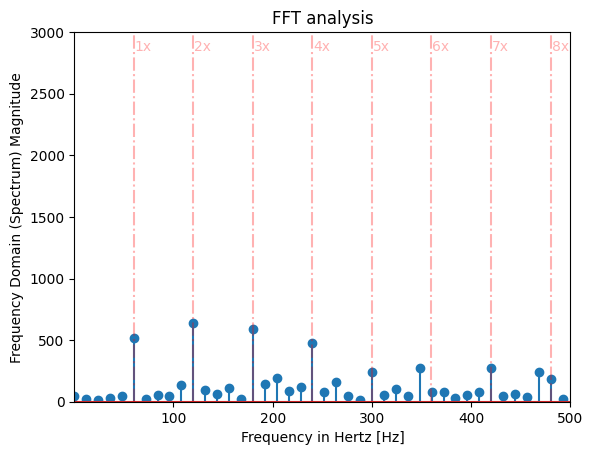

In [43]:
# Define plot variables
fig, ax = plt.subplots()
xlim = 500
ylim = 3000

# Config plot
ax.stem(freqs, np.abs(x_output_fft))
ax.set_title("FFT analysis")
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(sensor_min_freq_range, xlim)
ax.set_ylim(0, ylim)

# Add harmonics lines
for i in range(1,9):
    ax.axvline(x = sensor_trigger_sec * i, color = 'r', linestyle = "-.", alpha = 0.3)
    ax.text(sensor_trigger_sec * i + 1, ylim - 150, str(i) + 'x', color = 'r', alpha = 0.3)